# Cross-spectral analysis

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import scipy.signal
import os
import matplotlib.pyplot as plt
import nitime.algorithms as tsa
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA

In [2]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)
plt.rc({'axes.labelsize', 'medium'})

Define three functions. First the conversion to scale the graph to 10log10 aka decibel. Second the multitaper estimation method to compute the psd, csd, coherence and phase spectrum. Third is the uncertainty of the phase spectrum based on a monte carlo analysis method

In [3]:
def dB(x, out=None):
    if out is None:
        return 10 * np.log10(x)
    else:
        np.log10(x, out)
        np.multiply(out, 10, out)

def mtem(i, j, dt):
    """
    multitaper estimation method
    Input:
    i      first time series
    j      second time series

    Output:
    fki    power spectral density i
    fkj    power spectral density j
    cij    cross-spectral density ij
    coh    coherence
    ph     phase spectrum between ij at input freq
    
    """
    print 'i size', i.shape
    print 'j size', j.shape
    
    # apply multi taper cross spectral density from nitime module
    f, pcsd_est = tsa.multi_taper_csd(np.vstack([i,j]), Fs=1/dt, low_bias=True, adaptive=True, sides='onesided')
    
    # output is MxMxN matrix, extract the psd and csd
    fki = pcsd_est.diagonal().T[0]
    fkj = pcsd_est.diagonal().T[1]
    cij = pcsd_est.diagonal(+1).T.ravel()
    
    # using complex argument of cxy extract phase component
    ph = np.angle(cij)
    
    # calculate coherence using csd and psd
    coh = np.abs(cij)**2 / (fki * fkj)   
    
    return f, fki, fkj, cij, ph, coh 

def mtem_unct(i_, j_, dt_, cf, mc_no=20):
    """
    Uncertainty function using Monte Carlo analysis
    Input:
    i_     timeseries i
    j_     timeseries j
    cf     coherence function between i and j
    mc_no  number of iterations default is 20, minimum is 3
    
    Output:
    phif   phase uncertainty bounded between 0 and pi
    """
    print 'iteration no is', mc_no
    
    data = np.vstack([i_,j_])
    # number of iterations
    # flip coherence and horizontal stack    
    cg = np.hstack((cf[:-1], np.flipud(cf[:-1])))
    
    # random time series fi
    mc_fi = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fi = mc_fi / np.sum(abs(mc_fi),axis=1)[None].T
    
    # random time series fj
    mc_fj = np.random.standard_normal(size=(mc_no,len(data[0])))
    mc_fj = mc_fj / np.sum(abs(mc_fj),axis=1)[None].T
    
    # create semi random timeseries based on magnitude squared coherence
    # and inverse fourier transform for js
    js = np.real(np.fft.ifft(mc_fj * np.sqrt(1 - cg ** 2))) 
    js_ = js + np.real(np.fft.ifft(mc_fi *cg))
    
    # inverse fourier transform for xs
    is_ = np.real(np.fft.ifft(mc_fi))
    
    # spectral analysis
    f_s, pcsd_est = tsa.multi_taper_csd(np.vstack([is_,js_]), Fs=1/dt_, low_bias=True, adaptive=True, sides='onesided')
    cijx = pcsd_est.diagonal(+int(is_.shape[0])).T
    phi = np.angle(cijx)
    
    # sort and average the highest uncertianties
    pl = int(round(0.95*mc_no)+1)
    phi = np.sort(phi,axis=0)        
    phi = phi[((mc_no+1)-pl):pl]
    phi = np.array([phi[pl-2,:],-phi[pl-mc_no,:]])
    phi = phi.mean(axis=0)#
    phi = np.convolve(phi, np.array([1,1,1])/3)
    phif = phi[1:-1]
    return phif

Extract time series from satellite imagery, or create an artifical time series

In [4]:
end = 2000
dt=1
t = np.arange(0,end,dt)
rand1 = np.random.rand(end)
rand2 = np.random.rand(end)
i = 1*np.cos(2*np.pi*90/360+2*np.pi/21*t)+4*np.cos(+2*np.pi*10/360-2*np.pi/10*t)+1.5*(-1+2*rand1) # two freq

# for j prepared two functions, one time series that contain two freqs and one that contain one freq
j = 1*np.cos(2*np.pi*60/360+2*np.pi/21*t)+4*np.cos(-2*np.pi*70/360-2*np.pi/10*t)+1.5*(-1+2*rand2) # two freq
#j = 4*np.cos(-2*np.pi*70/360-2*np.pi/10*t)+1.5*(-1+2*rand2) # one freq

Plot the two timeseries as in

D:\Python27x64\lib\site-packages\matplotlib\font_manager.py:1287: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


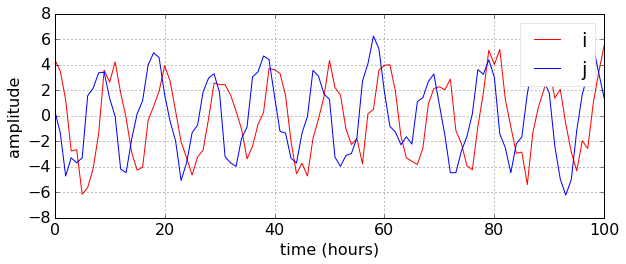

In [5]:
plt.figure(figsize=(9,4))
plt.subplot(111)
plt.grid()

plt.plot(t,i, 'r', lw=1, label='i')
plt.plot(t,j, 'b', lw=1, label='j')
plt.xlim(0,100)

plt.ylabel('amplitude')
plt.xlabel('time (hours)')
lg = plt.legend()
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//series_x_y.png', dpi=400)

Time series are correlated and contain causality. Specral analysis can provide insight at which frequencies there is correlation including the corresponding time lag

To estimate the time lag from the frequency domain, first the power spectral density (PSD) of both signals is estimated using the multi-taper estimation function. The objective of this method is to estimate the spectrum ($\hat{f}$) in the frequency ($\omega $) domain by taking $K$ tapers to obtain a set of $K$ eigenspectra including $k$ eigencomponents using time series ($i$ and $j$) with $N$ data points and constant sampling interval , so that $t=1,2,\dots ,N$. This set of eigenspectra of $i$ is defined as follow:

$${\hat{f}}^k_{ii}\left(\omega \right)={\left|\sum^N_{t=1}{{i\left(t\right)g}_k(t)e^{-\omega t}}\right|}^2$$

where $g_k(t)$ is the data taper for the $k$${}^{th}$ eigencomponent and $e^{-\omega t}$ the Fourier transform. The set of data tapers have the shape of Slepian sequences and provide a good protection against leakage. From here the final multitaper PSD (${\hat{f}}^{MT}$) is estimated by taking the mean as follows: 

$${\hat{f}}^{MT}_{ii}\left(\omega \right)=~\frac{1}{K}\sum^K_{k=1}{{\hat{f}}^k_{ii}\left(\omega \right)}$$

where ${\hat{f}}^k_{ii}\left(\omega \right)$ is the set of $K$ eigenspectra of $i$. The cross-spectral density (CSD) estimate is computed using the real valued PSD estimate of $i$ defined as ${\hat{f}}^{MT}_{ii}\left(\omega \right)$ and the complex conjugate of the PSD estimate of $j$ defined as ${\hat{f}}^{*MT}_{jj}\left(\omega \right)$ and given by:

$${\hat{f}}^{MT}_{ij}\left(\omega \right)=\frac{1}{N}\sum^N_{n=1}{{\hat{f}}^{MT}_{ii}\left(\omega \right)}{\hat{f}}^{*MT}_{jj}\left(\omega \right)$$

The estimate of the coherence ${\hat{C}oh}_{ij}\left(\omega \right)$ indicates how well $i$ correspond to $j$ at each frequency and is a measure of the strength of the relationship valued between 0 and 1 and defined as:

$${\hat{C}oh}_{ij}\left(\omega \right)=~\frac{{\left|\left.{\hat{f}}^{MT}_{ij}(\omega \right)\right|}^2}{\left.{\hat{f}}^{MT}_{ii}(\omega ){\hat{f}}^{MT}_{jj}(\omega \right)}$$

The phase spectrum estimate ${\varphi }_{ij}\left(\omega \right)$ is expressed in units of radian, is bound between -$\pi$ and $\pi$ and it is the phase difference at each frequency between $i$ and $j$. It is calculated from the imaginary and real part of the CSD:

$${\varphi }_{ij}\left(\omega \right)={{tan}^{-1} \left[\frac{\left.\mathrm{img}{\hat{f}}^{MT}_{ij}(\omega \right)}{\left.\mathrm{real}{\hat{f}}^{MT}_{ij}(\omega \right)}\right]\ }$$

where $\mathrm{img}{\hat{f}}^{MT}_{ij}(\omega )$ is the imaginary part of the CSD and $\left.\mathrm{real}{\hat{f}}^{MT}_{ij}(\omega \right)$ is the real part of the CSD. The time lag ${\varphi }_{ij}\left(t\right)$ is expressed in units of days and obtained from the phase spectrum as: 

$${\varphi }_{ij}\left(t\right)={{\varphi }_{ij}(\omega )}/{\left(2\pi \bullet \omega \right)}$$

where ${\varphi }_{ij}(\omega )$ is the phase in radian and $\omega $ is the radian frequency.

#### And it's coded as follow

In [6]:
f, fki, fkj, cij, ph, coh = mtem(i,j,dt)

i size (2000L,)
j size (2000L,)


Set some plot parameters

In [7]:
vspan_start1 = 0.0465
vspan_end1 = 0.0485
vspan_start2 = 0.099
vspan_end2 = 0.101
xlim_start = 0.000
xlim_end = 0.25

Plots of the result. First the psd of i and j.

D:\Python27x64\lib\site-packages\numpy\core\numeric.py:462: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


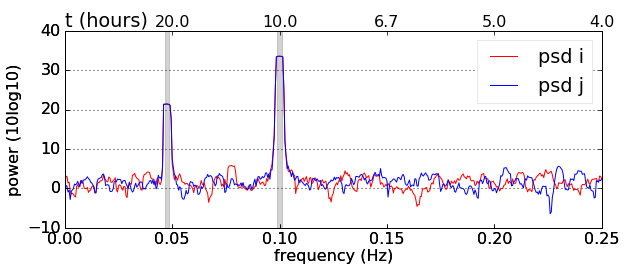

In [8]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

ax.grid(axis='y')
ax.plot(f,dB(fki), 'r-', lw=1, label ='psd i')
ax.plot(f,dB(fkj), 'b-', lw=1, label='psd j')
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
plt.ylim(-10,40)

ax.set_ylabel('power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
lg = plt.legend()
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//psd_x_y.png', dpi=400)

Timeseries of i contains noise and two components relating to frequency 0.1 and 0.047 Hz. Psd of j only contains one component related to frequency 0.1 Hz. Next we plot the cross spectral density and the corresponding coherence, which is the normalized csd.

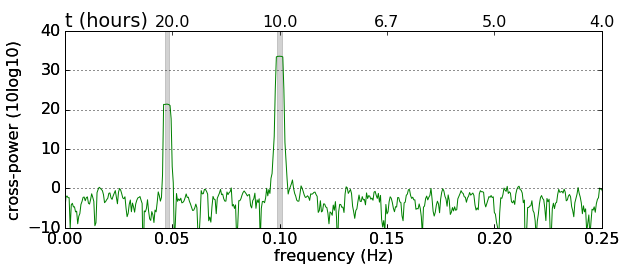

In [9]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

# aiaiaiai
ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

ax.grid(axis='y')
ax.plot(f,dB(cij), 'g-', lw=1, label='csd ij')
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
plt.ylim(-10,40)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//csd_x_y.png', dpi=400)

And the coherence

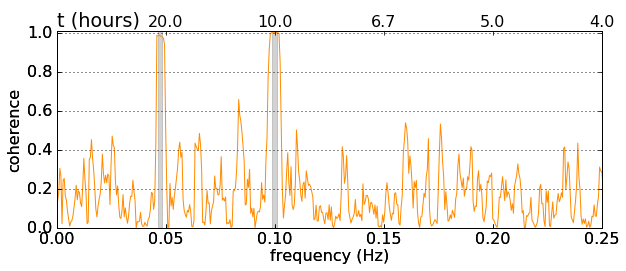

In [10]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

# plt.subplot(122)
ax.grid(axis='y')
ax.set_ylim([0,1.01])
ax.plot(f,coh, 'darkorange', label='coherence xy')

plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
ax.set_xlim(xlim_start,xlim_end)
# plt.ylim(0,1.01)

ax.set_ylabel('coherence')
ax.set_xlabel('frequency (Hz)')

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//coherence_x_y.png', dpi=400)

Next we plot the phase spectrum

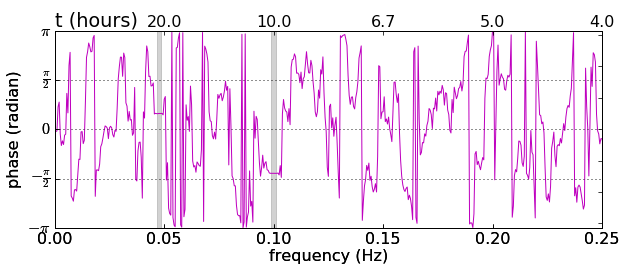

In [11]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (radian)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax.grid(axis='y')

plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-np.pi,np.pi)

plt.plot(f,ph, 'm', label='phase xy')
plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//phase_x_y.png', dpi=400)

The uncertainty of the phase-spectrum is estimated by applying a Monte-Carlo simulation. This method adopts a repeated semi-random sampling to obtain the distribution of the phase spectrum. The semi-random time series of $i$ and $j$ are created as follows:

$$i_{\mathrm{rand}}\left(t\right)=I\left(\omega \right)e^{+\omega t},$$$$j_{\mathrm{rand}}(t)=\left(J\left(\omega \right)\bullet \sqrt{1-{{\hat{C}oh}_{ij}\left(\omega \right)}^2}\right)e^{+\omega t}+J\left(\omega \right)e^{+\omega t}$$

where $I\left(\omega \right)$ and $J\left(\omega \right)$ are the Fourier transforms of the random realizations of the time series divided by the absolute sum of the norm of each realization (as in $I\left(\omega \right)=i_ne^{-\omega t}$; $I\left(\omega \right)={I(\omega )}/{\sum{\left|I(\omega )\right|}})$, and $e^{+\omega t}$ represent the inverse Fourier transform. Using these semi-random time series, the phase-spectrum is estimated for 100 Monte Carlo simulations and the phase values are estimated at the 95% confidence level.

### And it's coded as follow

In [12]:
phif = mtem_unct(i,j,dt,coh, mc_no=10)

iteration no is 10


D:\Python27x64\lib\site-packages\nitime\utils.py:571: RuntimeWarning: Breaking due to iterative meltdown in nitime.utils.adaptive_weights.
  warnings.warn(e_s, RuntimeWarning)


Next we plot the phase spectrum uncertainty

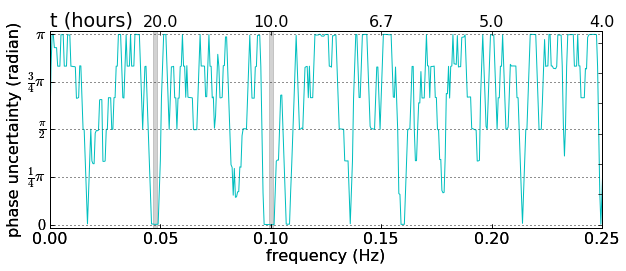

In [13]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi])
ax.set_yticklabels([r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', r'$\pi$'])

ax.set_ylabel('phase uncertainty (radian)')
ax.set_xlabel('frequency (Hz)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax.grid(axis='y')

ax.plot(f,phif, 'c', lw=1, label='uncertainty')
plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-0.05,3.2)

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//uncertainty_x_y.png', dpi=400)

Next we plot the phase spectrum + phase uncertainty

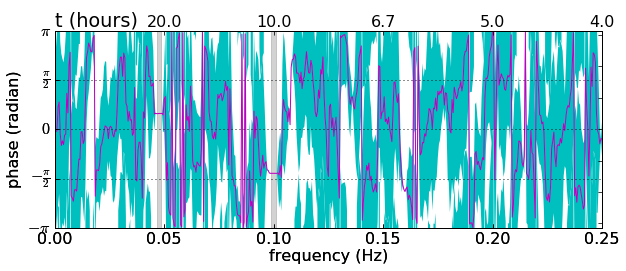

In [14]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (radian)')
ax.set_title('t (hours)', loc='left')

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax.grid(axis='y')

plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-np.pi,np.pi)

plt.plot(f,ph, 'm', label='phase xy')

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//phase_uncertainty_x_y.png', dpi=400)

Next we convert frequency-domain phase spectrum to time-domain time lag

In [15]:
rad2time = ph/(2*np.pi*f)
mtcl2time = phif/(2*np.pi*f)
neg_time= np.where(rad2time<0)
dur_cycl = (1/f)
rad2time[neg_time] = rad2time[neg_time]+dur_cycl[neg_time]

D:\Python27x64\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:2: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in less
  app.launch_new_instance()
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in true_divide


D:\Python27x64\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in less
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in greater
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in greater
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:10: RuntimeWarning: invalid value encountered in less


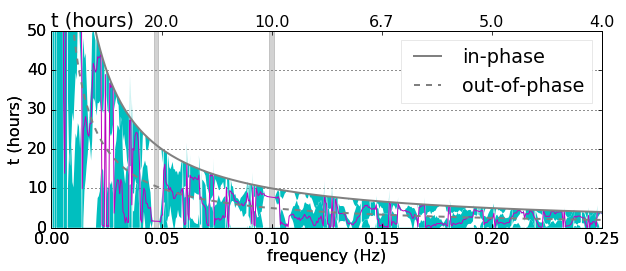

In [16]:
plt.figure(figsize=(9,4))
ax = host_subplot(111, axes_class=AA.Axes)

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', label='Phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-', lw=2, label='in-phase')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', lw=2, label='out-of-phase')

ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([0,50])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('t (hours)')
ax.set_title('t (hours)', loc='left')

p5 = plt.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
plt.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)

lg = plt.legend([p3,p4], ['in-phase','out-of-phase'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0)

plt.gcf().tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//phase_uncertainty_hours_x_y.png', dpi=400)

### Just for fun, all in one plot

D:\Python27x64\lib\site-packages\ipykernel\__main__.py:143: RuntimeWarning: invalid value encountered in less
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:145: RuntimeWarning: invalid value encountered in greater
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:147: RuntimeWarning: invalid value encountered in greater
D:\Python27x64\lib\site-packages\ipykernel\__main__.py:149: RuntimeWarning: invalid value encountered in less


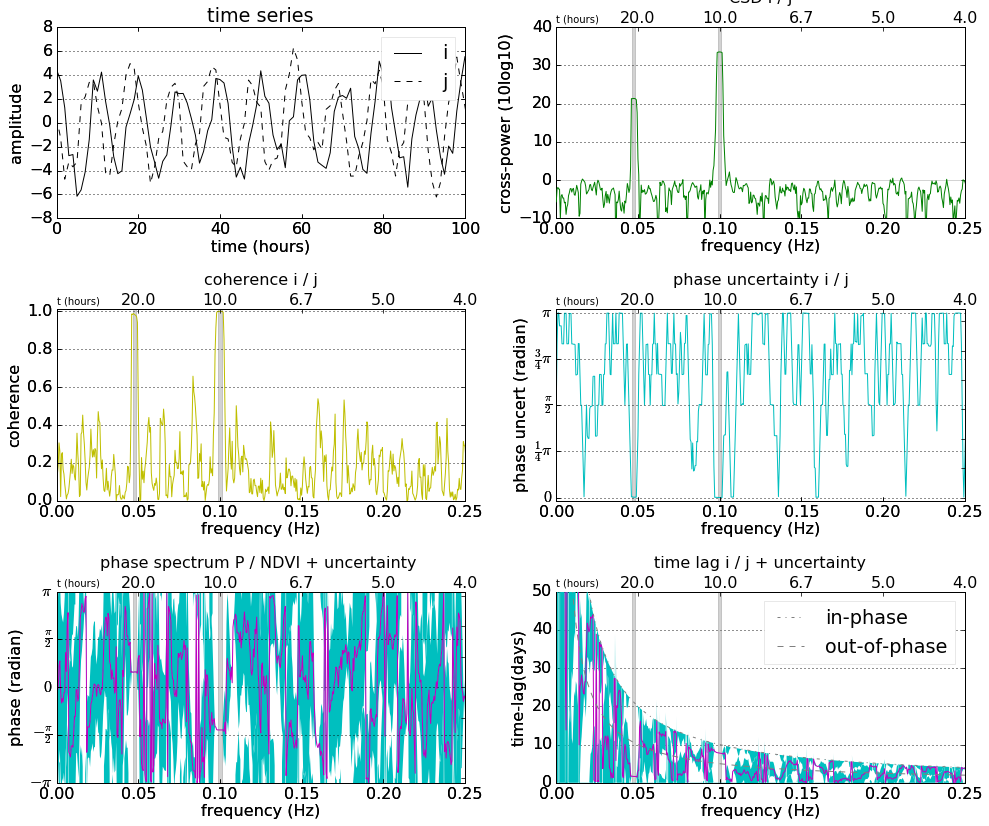

In [17]:
plt.rcParams.update({'axes.labelsize': 'medium'})
#plt.figure(figsize=(10,8.55))
plt.figure(figsize=(14.04,12))
# plot time series
ax = host_subplot(321, axes_class=AA.Axes)
ax.grid(axis='y')

p1, = ax.plot(t,i, 'k-', lw=1, label='i')
p2, = ax.plot(t,j, 'k--', lw=1, label='j')
ax.set_xlim(0,100)

ax.set_ylabel('amplitude')
ax.set_xlabel('time (hours)')
ax.set_title('time series')
lg = plt.legend([p1,p2], ['i','j'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)

ax = host_subplot(322, axes_class=AA.Axes)
ax.set_xlim([xlim_start,xlim_end])
ax.set_ylim([-10,40])
ax.axhline(zorder=2, color='lightgray')
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left', fontsize=10)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('CSD i / j', fontsize=25)
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

ax.grid(axis='y', zorder =1)
ax.plot(f,dB(cij), 'g-', lw=1, zorder =4)
ax.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
ax.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_ylabel('cross-power (10log10)') # regex: ($10log10$)
ax.set_xlabel('frequency (Hz)')
#ax.set_yscale('symlog')

# plot csd
ax = host_subplot(323, axes_class=AA.Axes)

ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left', fontsize=10)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('coherence i / j')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)

ax.grid(axis='y')
ax.set_ylim([0,1.01])
ax.plot(f,coh, 'y')

ax.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
ax.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
ax.set_xlim(xlim_start,xlim_end)

ax.set_ylabel('coherence')
ax.set_xlabel('frequency (Hz)')

# plot coherence
ax = host_subplot(324, axes_class=AA.Axes)
ax.set_xlim([xlim_start,xlim_end])

ax.set_yticks([0,1./4*np.pi, np.pi/2, 3./4*np.pi,np.pi])
ax.set_yticklabels([r'$0$', r'$\frac{1}{4}\pi$', r'$\frac{\pi}{2}$', r'$\frac{3}{4}\pi$', r'$\pi$'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left', fontsize=10)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase uncertainty i / j')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)
ax.grid(axis='y')

ax.plot(f,phif, 'c', lw=1)
ax.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
ax.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)
ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-0.05,3.2)

ax.set_ylabel('phase uncert (radian)')
ax.set_xlabel('frequency (Hz)')

#plot uncertainty
ax = host_subplot(325, axes_class=AA.Axes)
ax.set_xlim([xlim_start,xlim_end])

ax.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax.set_yticklabels(['$-\pi$', r'$-\frac{\pi}{2}$', r'$0$', r'$\frac{\pi}{2}$', r'$\pi$'])

ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('phase (day)')
ax.set_title('t (hours)', loc='left', fontsize=10)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('phase spectrum P / NDVI + uncertainty ')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)
ax.grid(axis='y')

ax.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
ax.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax.set_xlim(xlim_start,xlim_end)
ax.set_ylim(-np.pi,np.pi)

ax.set_xlabel('frequency (Hz)')
plt.plot(f,ph, 'm')

plt.fill_between(f,ph,(ph-phif),facecolor='c' ,edgecolor='c', lw=0.0)#, where=(ph-phif)>=-np.pi)
plt.fill_between(f,ph,(ph+phif),facecolor='c' ,edgecolor='c', lw=0.0)

plt.fill_between(f,(ph+2*np.pi),((ph+2*np.pi)-phif), where=(ph-phif)<=-np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)
plt.fill_between(f,(ph-2*np.pi),((ph-2*np.pi)+phif), where=(ph+phif)>=np.pi,
                 facecolor='c' ,edgecolor='c', lw=0.0)

ax.set_ylabel('phase (radian)')

# plot phase + uncertainty
ax = host_subplot(326, axes_class=AA.Axes)

p1 = plt.Rectangle((0, 0), 1, 1, fc='c', ec='c')
p2, = ax.plot(f, rad2time, color='m', zorder=5, label='phase')
p3, = ax.plot(f, dur_cycl, color='gray', linestyle='-.', zorder=5, label='in-phase')
p4, = ax.plot(f, dur_cycl/2, color='gray', linestyle='--', zorder=5, label='out-of-phase')

ax.fill_between(f,(rad2time+mtcl2time),(rad2time-mtcl2time), where=(((rad2time+mtcl2time)<dur_cycl)), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time-mtcl2time),dur_cycl, where=(((rad2time+mtcl2time)>dur_cycl)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,(rad2time+mtcl2time)-dur_cycl, where=(((rad2time+mtcl2time)>0)),
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)
ax.fill_between(f,((rad2time-mtcl2time)+dur_cycl),dur_cycl, where=((rad2time-mtcl2time)<0), 
             facecolor='c' ,edgecolor='c', lw=0.0 ,interpolate=True, zorder=4)

ax.set_xlim([xlim_start,xlim_end])
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('time-lag(days)')
ax.set_title('t (hours)', loc='left', fontsize=10)
ax.set_ylim([0,50])

p5 = ax.axvspan(vspan_start1,vspan_end1, color='gray', alpha=0.35)
ax.axvspan(vspan_start2,vspan_end2, color='gray', alpha=0.35)

ax2 = ax.twin() # ax2 is responsible for "top" axis and "right" axis
ax2.set_xlabel('time lag i / j + uncertainty')
ax2.set_xticks([(0.05),(0.1),(0.15),(0.2), (0.25)])
ax2.set_xticklabels([str(1./0.05),str(1./0.1),str(round(1./0.15,1)),str(1./0.2),str(1./0.25)])
ax2.axis["right"].major_ticklabels.set_visible(False)
ax2.xaxis.label.set_size(2)


lg = plt.legend([p3,p4], ['in-phase','out-of-phase'], ncol=1)
lg.get_frame().set_ec('lightgray')
lg.get_frame().set_lw(0.5)
plt.grid(axis='y', zorder=0 )

plt.tight_layout()
#plt.savefig(r'C:\Users\lenovo.lenovo-PC.000\Documents\images_oral_defense//cross_spectral.png', dpi=400, pad_inches=0.1)